In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set visualization parameters
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 10

print("Layer 4: Early Warning System - Initialization Complete")
print(f"Execution Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Layer 4: Early Warning System - Initialization Complete
Execution Time: 2026-01-15 21:10:09


## 1. Load All Layer Metrics

In [2]:
# Load Layer 1: Migration metrics
layer1 = pd.read_csv('../outputs/layer1_migration_metrics.csv')
print(f"Layer 1 loaded: {layer1.shape[0]} districts, {layer1.shape[1]} metrics")

# Load Layer 2: Child risk metrics
layer2 = pd.read_csv('../outputs/layer2_child_risk_metrics.csv')
print(f"Layer 2 loaded: {layer2.shape[0]} districts, {layer2.shape[1]} metrics")

# Load Layer 3: System intelligence metrics
layer3 = pd.read_csv('../outputs/layer3_system_intelligence.csv')
print(f"Layer 3 loaded: {layer3.shape[0]} districts, {layer3.shape[1]} metrics")

# Merge all layers
integrated_data = layer1.merge(layer2[['district', 'state', 'child_risk_score', 'child_share_pct', 'lag_index']], 
                                on=['district', 'state'], how='inner')
integrated_data = integrated_data.merge(layer3[['district', 'state', 'DSI', 'ADP', 'Quadrant']], 
                                        on=['district', 'state'], how='inner')

print(f"\nIntegrated dataset: {integrated_data.shape[0]} districts, {integrated_data.shape[1]} total metrics")
integrated_data.head(3)

Layer 1 loaded: 1056 districts, 16 metrics
Layer 2 loaded: 1056 districts, 20 metrics
Layer 3 loaded: 1056 districts, 16 metrics

Integrated dataset: 1056 districts, 22 total metrics


,district,state,mean_adult_updates,volatility,avg_growth_rate,max_growth_rate,spike_amplitude,coefficient_variation,baseline_volume,migration_pressure_score,...,vol_norm,growth_norm,baseline_inv_norm,high_churn,child_risk_score,child_share_pct,lag_index,DSI,ADP,Quadrant
0,100000,100000,3.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,...,0.0,0.0,0.999906,False,25.0,0.0,0,90.017898,50.003602,"Q1: High Stability, High Dependency"
1,561203,561203,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.999969,False,25.0,0.0,0,90.017898,50.001201,"Q1: High Stability, High Dependency"
2,5Th Cross,Puttenahalli,2.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,...,0.0,0.0,0.999937,False,25.0,0.0,0,90.017898,50.002401,"Q1: High Stability, High Dependency"


## 2. Define Rule-Based Alert Thresholds

In [3]:
# Rule-based threshold definitions (fully explainable)
ALERT_RULES = {
    # Migration alerts
    'migration_volatility_high': {'metric': 'volatility', 'threshold': 5000, 'operator': '>'},
    'migration_pressure_critical': {'metric': 'migration_pressure_score', 'threshold': 10000, 'operator': '>'},
    'growth_spike': {'metric': 'avg_growth_rate', 'threshold': 100, 'operator': '>'},
    'decline_rapid': {'metric': 'avg_growth_rate', 'threshold': -20, 'operator': '<'},
    
    # Child risk alerts
    'child_risk_high': {'metric': 'child_risk_score', 'threshold': 50, 'operator': '>'},
    'child_share_low': {'metric': 'child_share_pct', 'threshold': 5, 'operator': '<'},
    'documentation_lag': {'metric': 'lag_index', 'threshold': 2, 'operator': '>='},
    
    # System intelligence alerts
    'stability_low': {'metric': 'DSI', 'threshold': 40, 'operator': '<'},
    'dependency_high': {'metric': 'ADP', 'threshold': 60, 'operator': '>'},
    'critical_zone': {'metric': 'Quadrant', 'threshold': 'Q2: Low Stability, High Dependency', 'operator': '=='},
}

# Alert severity levels
SEVERITY_LEVELS = {
    'CRITICAL': 4,  # Multiple high-severity alerts
    'HIGH': 3,      # Single high-severity alert or multiple moderate
    'MODERATE': 2,  # Single moderate alert
    'LOW': 1,       # Single low-priority alert
    'NORMAL': 0     # No alerts
}

print("Alert Rules Defined:")
for alert_name, rule in ALERT_RULES.items():
    print(f"  - {alert_name}: {rule['metric']} {rule['operator']} {rule['threshold']}")

Alert Rules Defined:
  - migration_volatility_high: volatility > 5000
  - migration_pressure_critical: migration_pressure_score > 10000
  - growth_spike: avg_growth_rate > 100
  - decline_rapid: avg_growth_rate < -20
  - child_risk_high: child_risk_score > 50
  - child_share_low: child_share_pct < 5
  - documentation_lag: lag_index >= 2
  - stability_low: DSI < 40
  - dependency_high: ADP > 60
  - critical_zone: Quadrant == Q2: Low Stability, High Dependency


## 3. Implement Rule-Based Anomaly Detection

In [4]:
def apply_alert_rule(data, rule_name, rule_config):
    """
    Apply a single alert rule to the dataset.
    Returns boolean series indicating which districts trigger the alert.
    """
    metric = rule_config['metric']
    threshold = rule_config['threshold']
    operator = rule_config['operator']
    
    if operator == '>':
        return data[metric] > threshold
    elif operator == '<':
        return data[metric] < threshold
    elif operator == '>=':
        return data[metric] >= threshold
    elif operator == '<=':
        return data[metric] <= threshold
    elif operator == '==':
        return data[metric] == threshold
    else:
        return pd.Series([False] * len(data))

# Apply all alert rules
alert_data = integrated_data.copy()

for alert_name, rule_config in ALERT_RULES.items():
    alert_data[f'alert_{alert_name}'] = apply_alert_rule(alert_data, alert_name, rule_config)

# Count total alerts per district
alert_columns = [col for col in alert_data.columns if col.startswith('alert_')]
alert_data['total_alerts'] = alert_data[alert_columns].sum(axis=1)

print(f"Alert Detection Complete:")
print(f"  Total districts analyzed: {len(alert_data)}")
print(f"  Districts with alerts: {(alert_data['total_alerts'] > 0).sum()}")
print(f"  Districts with no alerts: {(alert_data['total_alerts'] == 0).sum()}")
print(f"\nAlert Distribution:")
print(alert_data['total_alerts'].value_counts().sort_index())

Alert Detection Complete:
  Total districts analyzed: 1056
  Districts with alerts: 556
  Districts with no alerts: 500

Alert Distribution:
total_alerts
0    500
1    390
2    123
3     31
4      8
5      4
Name: count, dtype: int64


## 4. Calculate Z-Score Deviations

In [5]:
# Calculate Z-scores for key metrics
z_score_metrics = ['volatility', 'migration_pressure_score', 'child_risk_score', 'DSI', 'ADP']

for metric in z_score_metrics:
    mean_val = alert_data[metric].mean()
    std_val = alert_data[metric].std()
    alert_data[f'{metric}_zscore'] = (alert_data[metric] - mean_val) / std_val
    
    # Flag extreme deviations (|z| > 2)
    alert_data[f'{metric}_extreme'] = np.abs(alert_data[f'{metric}_zscore']) > 2

# Count extreme deviations
extreme_columns = [col for col in alert_data.columns if col.endswith('_extreme')]
alert_data['extreme_deviations'] = alert_data[extreme_columns].sum(axis=1)

print("Z-Score Analysis:")
for metric in z_score_metrics:
    extreme_count = alert_data[f'{metric}_extreme'].sum()
    print(f"  {metric}: {extreme_count} districts with |z| > 2")

Z-Score Analysis:
  volatility: 53 districts with |z| > 2
  migration_pressure_score: 6 districts with |z| > 2
  child_risk_score: 75 districts with |z| > 2
  DSI: 57 districts with |z| > 2
  ADP: 48 districts with |z| > 2


## 5. Generate Alert Classification & Priority Scores

In [6]:
def calculate_alert_severity(row):
    """
    Calculate alert severity based on number and type of alerts triggered.
    """
    # Critical alerts (high-impact signals)
    critical_alerts = [
        row['alert_migration_pressure_critical'],
        row['alert_child_risk_high'],
        row['alert_critical_zone']
    ]
    
    # High-priority alerts
    high_alerts = [
        row['alert_migration_volatility_high'],
        row['alert_growth_spike'],
        row['alert_decline_rapid'],
        row['alert_dependency_high'],
        row['alert_stability_low']
    ]
    
    # Moderate-priority alerts
    moderate_alerts = [
        row['alert_child_share_low'],
        row['alert_documentation_lag']
    ]
    
    critical_count = sum(critical_alerts)
    high_count = sum(high_alerts)
    moderate_count = sum(moderate_alerts)
    
    # Severity classification logic
    if critical_count >= 2 or (critical_count >= 1 and high_count >= 2):
        return 'CRITICAL'
    elif critical_count >= 1 or high_count >= 2:
        return 'HIGH'
    elif high_count >= 1 or moderate_count >= 2:
        return 'MODERATE'
    elif moderate_count >= 1:
        return 'LOW'
    else:
        return 'NORMAL'

# Apply severity classification
alert_data['alert_severity'] = alert_data.apply(calculate_alert_severity, axis=1)

# Calculate priority score (0-100)
alert_data['priority_score'] = (
    alert_data['total_alerts'] * 5 +  # Base alert count
    alert_data['extreme_deviations'] * 10 +  # Extreme statistical deviations
    alert_data['migration_pressure_score'] / 1000 +  # Migration pressure
    alert_data['child_risk_score'] * 0.5 +  # Child risk
    (100 - alert_data['DSI']) * 0.2  # Inverse stability
).clip(0, 100)

print("\nAlert Severity Distribution:")
print(alert_data['alert_severity'].value_counts())
print(f"\nPriority Score Statistics:")
print(alert_data['priority_score'].describe())


Alert Severity Distribution:
alert_severity
NORMAL      500
MODERATE    314
LOW         139
HIGH         93
CRITICAL     10
Name: count, dtype: int64

Priority Score Statistics:
count    1056.000000
mean       24.533650
std        12.858313
min         9.694943
25%        16.859993
50%        19.949491
75%        26.049628
max       100.000000
Name: priority_score, dtype: float64


## 6. Identify Priority Intervention Districts

In [7]:
# Filter districts requiring intervention
priority_districts = alert_data[
    alert_data['alert_severity'].isin(['CRITICAL', 'HIGH', 'MODERATE'])
].copy()

# Sort by priority score
priority_districts = priority_districts.sort_values('priority_score', ascending=False)

print(f"Priority Intervention Districts: {len(priority_districts)}")
print(f"\nBreakdown by Severity:")
print(priority_districts['alert_severity'].value_counts())

# Top 20 highest priority districts
print(f"\n{'='*80}")
print("TOP 20 HIGHEST PRIORITY DISTRICTS FOR IMMEDIATE INTERVENTION")
print(f"{'='*80}")

top20 = priority_districts.head(20)[[
    'district', 'state', 'alert_severity', 'total_alerts', 
    'priority_score', 'migration_pressure_score', 'child_risk_score', 'DSI', 'ADP'
]]

for idx, row in top20.iterrows():
    print(f"\n{row.name + 1}. {row['district']}, {row['state']}")
    print(f"   Severity: {row['alert_severity']} | Priority Score: {row['priority_score']:.1f} | Alerts: {row['total_alerts']}")
    print(f"   Migration: {row['migration_pressure_score']:.0f} | Child Risk: {row['child_risk_score']:.1f} | DSI: {row['DSI']:.1f} | ADP: {row['ADP']:.1f}")

Priority Intervention Districts: 417

Breakdown by Severity:
alert_severity
MODERATE    314
HIGH         93
CRITICAL     10
Name: count, dtype: int64

TOP 20 HIGHEST PRIORITY DISTRICTS FOR IMMEDIATE INTERVENTION

84. Balotra, Rajasthan
   Severity: CRITICAL | Priority Score: 100.0 | Alerts: 3
   Migration: 117181 | Child Risk: 24.0 | DSI: 34.9 | ADP: 21.0

119. Beawar, Rajasthan
   Severity: CRITICAL | Priority Score: 100.0 | Alerts: 4
   Migration: 38605 | Child Risk: 22.7 | DSI: 32.7 | ADP: 20.5

506. Khairthal-Tijara, Rajasthan
   Severity: CRITICAL | Priority Score: 100.0 | Alerts: 3
   Migration: 134681 | Child Risk: 21.4 | DSI: 37.5 | ADP: 22.0

1029. Washim *, Maharashtra
   Severity: CRITICAL | Priority Score: 96.6 | Alerts: 5
   Migration: 617 | Child Risk: 50.9 | DSI: 22.2 | ADP: 12.7

543. Kotputli-Behror, Rajasthan
   Severity: CRITICAL | Priority Score: 95.8 | Alerts: 3
   Migration: 37711 | Child Risk: 21.0 | DSI: 36.9 | ADP: 21.6

168. Buldana, Maharashtra
   Severity: C

## 7. Generate Alert Type Analysis

In [8]:
# Count frequency of each alert type
alert_frequency = {}
for alert_name in ALERT_RULES.keys():
    col_name = f'alert_{alert_name}'
    alert_frequency[alert_name] = alert_data[col_name].sum()

# Create DataFrame for analysis
alert_freq_df = pd.DataFrame([
    {'alert_type': k, 'districts_affected': v, 'percentage': v/len(alert_data)*100}
    for k, v in alert_frequency.items()
]).sort_values('districts_affected', ascending=False)

print("\nAlert Type Frequency Analysis:")
print(f"{'='*70}")
for _, row in alert_freq_df.iterrows():
    print(f"{row['alert_type']:30} {row['districts_affected']:4.0f} districts ({row['percentage']:5.1f}%)")

# Identify common alert combinations
print(f"\n{'='*70}")
print("Most Common Alert Combinations (districts with 2+ alerts):")
multi_alert_districts = alert_data[alert_data['total_alerts'] >= 2]
print(f"Total districts with multiple alerts: {len(multi_alert_districts)}")


Alert Type Frequency Analysis:
migration_volatility_high       274 districts ( 25.9%)
child_share_low                 206 districts ( 19.5%)
growth_spike                     98 districts (  9.3%)
decline_rapid                    73 districts (  6.9%)
documentation_lag                51 districts (  4.8%)
stability_low                    31 districts (  2.9%)
dependency_high                  30 districts (  2.8%)
child_risk_high                   9 districts (  0.9%)
migration_pressure_critical       6 districts (  0.6%)
critical_zone                     3 districts (  0.3%)

Most Common Alert Combinations (districts with 2+ alerts):
Total districts with multiple alerts: 166


## 8. Visualization: Early Warning Dashboard


Visualization saved: layer4_alert_dashboard.png


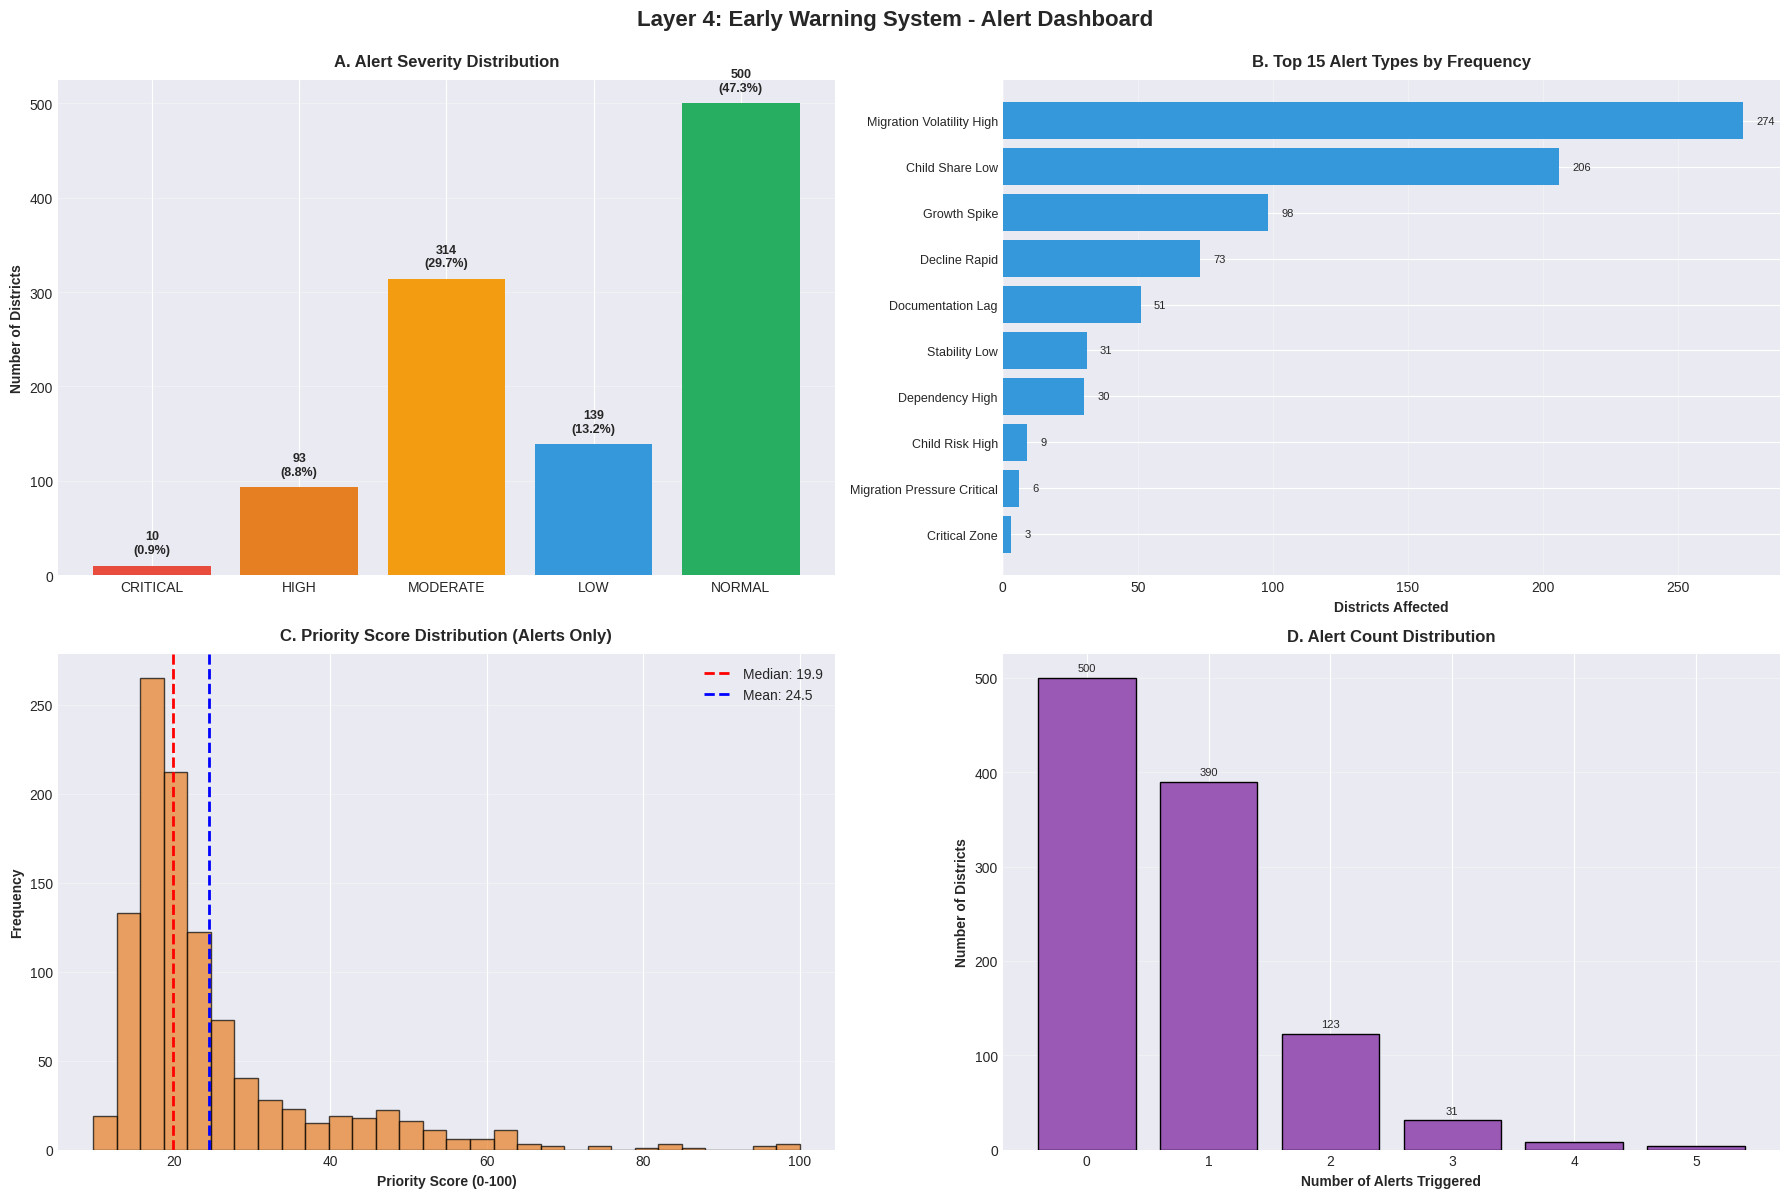

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Layer 4: Early Warning System - Alert Dashboard', fontsize=16, fontweight='bold', y=0.995)

# Panel 1: Alert Severity Distribution
ax1 = axes[0, 0]
severity_counts = alert_data['alert_severity'].value_counts()
colors_severity = {'CRITICAL': '#e74c3c', 'HIGH': '#e67e22', 'MODERATE': '#f39c12', 'LOW': '#3498db', 'NORMAL': '#27ae60'}
severity_order = ['CRITICAL', 'HIGH', 'MODERATE', 'LOW', 'NORMAL']
severity_counts = severity_counts.reindex(severity_order)
bars1 = ax1.bar(range(len(severity_counts)), severity_counts.values, 
                color=[colors_severity[x] for x in severity_counts.index])
ax1.set_xticks(range(len(severity_counts)))
ax1.set_xticklabels(severity_counts.index, rotation=0)
ax1.set_ylabel('Number of Districts', fontweight='bold')
ax1.set_title('A. Alert Severity Distribution', fontweight='bold', pad=10)
ax1.grid(axis='y', alpha=0.3)
for i, (idx, val) in enumerate(severity_counts.items()):
    ax1.text(i, val + 10, f'{val}\n({val/len(alert_data)*100:.1f}%)', 
             ha='center', va='bottom', fontweight='bold', fontsize=9)

# Panel 2: Top 15 Alert Types
ax2 = axes[0, 1]
top_alerts = alert_freq_df.head(15)
bars2 = ax2.barh(range(len(top_alerts)), top_alerts['districts_affected'].values, color='#3498db')
ax2.set_yticks(range(len(top_alerts)))
ax2.set_yticklabels([x.replace('_', ' ').title() for x in top_alerts['alert_type']], fontsize=9)
ax2.set_xlabel('Districts Affected', fontweight='bold')
ax2.set_title('B. Top 15 Alert Types by Frequency', fontweight='bold', pad=10)
ax2.grid(axis='x', alpha=0.3)
ax2.invert_yaxis()
for i, val in enumerate(top_alerts['districts_affected'].values):
    ax2.text(val + 5, i, f'{val:.0f}', va='center', fontsize=8)

# Panel 3: Priority Score Distribution
ax3 = axes[1, 0]
priority_data = alert_data[alert_data['priority_score'] > 0]['priority_score']
ax3.hist(priority_data, bins=30, color='#e67e22', edgecolor='black', alpha=0.7)
ax3.axvline(priority_data.median(), color='red', linestyle='--', linewidth=2, label=f'Median: {priority_data.median():.1f}')
ax3.axvline(priority_data.mean(), color='blue', linestyle='--', linewidth=2, label=f'Mean: {priority_data.mean():.1f}')
ax3.set_xlabel('Priority Score (0-100)', fontweight='bold')
ax3.set_ylabel('Frequency', fontweight='bold')
ax3.set_title('C. Priority Score Distribution (Alerts Only)', fontweight='bold', pad=10)
ax3.legend(loc='upper right')
ax3.grid(axis='y', alpha=0.3)

# Panel 4: Total Alerts per District
ax4 = axes[1, 1]
alert_counts = alert_data['total_alerts'].value_counts().sort_index()
bars4 = ax4.bar(alert_counts.index, alert_counts.values, color='#9b59b6', edgecolor='black')
ax4.set_xlabel('Number of Alerts Triggered', fontweight='bold')
ax4.set_ylabel('Number of Districts', fontweight='bold')
ax4.set_title('D. Alert Count Distribution', fontweight='bold', pad=10)
ax4.grid(axis='y', alpha=0.3)
for i, (idx, val) in enumerate(alert_counts.items()):
    if val > 20:  # Only label significant bars
        ax4.text(idx, val + 5, f'{val}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('../outputs/layer4_alert_dashboard.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved: layer4_alert_dashboard.png")
plt.show()

## 9. State-Level Alert Summary

In [10]:
# State-level aggregation
state_alerts = alert_data.groupby('state').agg({
    'district': 'count',
    'total_alerts': 'sum',
    'priority_score': 'mean'
}).rename(columns={'district': 'total_districts'})

state_alerts['alerts_per_district'] = state_alerts['total_alerts'] / state_alerts['total_districts']

# Count districts by severity per state
severity_by_state = alert_data.groupby(['state', 'alert_severity']).size().unstack(fill_value=0)
state_alerts = state_alerts.join(severity_by_state)

# Sort by priority
state_alerts['critical_high_count'] = state_alerts['CRITICAL'] + state_alerts['HIGH']
state_alerts = state_alerts.sort_values('critical_high_count', ascending=False)

print("\nState-Level Alert Summary (Top 20 by Critical+High Districts):")
print(f"{'='*100}")
print(f"{'State':<25} {'Total':>6} {'Critical':>8} {'High':>6} {'Moderate':>9} {'Avg Priority':>12}")
print(f"{'='*100}")

for state, row in state_alerts.head(20).iterrows():
    print(f"{state:<25} {row['total_districts']:>6.0f} {row.get('CRITICAL', 0):>8.0f} "
          f"{row.get('HIGH', 0):>6.0f} {row.get('MODERATE', 0):>9.0f} {row['priority_score']:>12.1f}")


State-Level Alert Summary (Top 20 by Critical+High Districts):
State                      Total Critical   High  Moderate Avg Priority
Maharashtra                   53        5     20        15         48.0
West Bengal                   47        0     15        10         31.5
Bihar                         47        0     13        19         28.9
Uttar Pradesh                 89        0     12        57         30.4
Tamil Nadu                    46        0      9        10         22.0
Rajasthan                     45        5      2        30         39.0
Chhattisgarh                  39        0      3         9         21.4
Jharkhand                     33        0      3        14         21.9
Andhra Pradesh                45        0      3        14         21.2
Manipur                       13        0      2         5         29.3
Odisha                        41        0      2        19         19.8
Telangana                     41        0      2         8         21.5


## 10. Generate Alert Reports

In [11]:
# Export comprehensive alert dataset
alert_export = alert_data[[
    'district', 'state', 'alert_severity', 'total_alerts', 'priority_score',
    'migration_pressure_score', 'child_risk_score', 'DSI', 'ADP', 'Quadrant',
    'extreme_deviations'
] + alert_columns].sort_values('priority_score', ascending=False)

alert_export.to_csv('../outputs/layer4_early_warning_alerts.csv', index=False)
print("Exported: layer4_early_warning_alerts.csv")

# Export priority districts (CRITICAL + HIGH only)
priority_export = priority_districts[
    priority_districts['alert_severity'].isin(['CRITICAL', 'HIGH'])
][[
    'district', 'state', 'alert_severity', 'total_alerts', 'priority_score',
    'migration_pressure_score', 'child_risk_score', 'DSI', 'ADP'
]].sort_values('priority_score', ascending=False)

priority_export.to_csv('../outputs/layer4_priority_intervention_districts.csv', index=False)
print(f"Exported: layer4_priority_intervention_districts.csv ({len(priority_export)} districts)")

# Alert frequency analysis
alert_freq_df.to_csv('../outputs/layer4_alert_frequency.csv', index=False)
print("Exported: layer4_alert_frequency.csv")

Exported: layer4_early_warning_alerts.csv
Exported: layer4_priority_intervention_districts.csv (103 districts)
Exported: layer4_alert_frequency.csv


## 11. Generate Summary Report

In [12]:
# Generate comprehensive summary report
report_lines = []
report_lines.append("="*80)
report_lines.append("LAYER 4: EARLY WARNING SYSTEM - SUMMARY REPORT")
report_lines.append("Rule-Based Alert Framework")
report_lines.append("="*80)
report_lines.append(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
report_lines.append(f"Total Districts Analyzed: {len(alert_data):,}")
report_lines.append("")

report_lines.append("-"*80)
report_lines.append("1. ALERT SEVERITY DISTRIBUTION")
report_lines.append("-"*80)
for severity in ['CRITICAL', 'HIGH', 'MODERATE', 'LOW', 'NORMAL']:
    count = (alert_data['alert_severity'] == severity).sum()
    pct = count / len(alert_data) * 100
    report_lines.append(f"  {severity:12} : {count:4} districts ({pct:5.1f}%)")
report_lines.append("")

report_lines.append("-"*80)
report_lines.append("2. PRIORITY INTERVENTION DISTRICTS")
report_lines.append("-"*80)
critical_count = (alert_data['alert_severity'] == 'CRITICAL').sum()
high_count = (alert_data['alert_severity'] == 'HIGH').sum()
moderate_count = (alert_data['alert_severity'] == 'MODERATE').sum()
report_lines.append(f"  Critical Priority : {critical_count} districts (immediate action required)")
report_lines.append(f"  High Priority     : {high_count} districts (urgent intervention needed)")
report_lines.append(f"  Moderate Priority : {moderate_count} districts (enhanced monitoring)")
report_lines.append(f"  Total Intervention: {critical_count + high_count + moderate_count} districts")
report_lines.append("")

report_lines.append("-"*80)
report_lines.append("3. TOP 10 ALERT TYPES")
report_lines.append("-"*80)
for idx, row in alert_freq_df.head(10).iterrows():
    report_lines.append(f"  {row['alert_type']:30} {row['districts_affected']:4.0f} districts ({row['percentage']:5.1f}%)")
report_lines.append("")

report_lines.append("-"*80)
report_lines.append("4. TOP 15 PRIORITY DISTRICTS (IMMEDIATE INTERVENTION)")
report_lines.append("-"*80)
for i, (idx, row) in enumerate(priority_districts.head(15).iterrows(), 1):
    report_lines.append(f"\n{i:2}. {row['district']}, {row['state']}")
    report_lines.append(f"    Severity: {row['alert_severity']} | Priority Score: {row['priority_score']:.1f} | Alerts: {row['total_alerts']}")
    report_lines.append(f"    Migration Pressure: {row['migration_pressure_score']:.0f} | Child Risk: {row['child_risk_score']:.1f}")
    report_lines.append(f"    DSI: {row['DSI']:.1f} | ADP: {row['ADP']:.1f} | Quadrant: {row['Quadrant']}")

report_lines.append("\n" + "-"*80)
report_lines.append("5. STATISTICAL SUMMARY")
report_lines.append("-"*80)
report_lines.append(f"  Mean Alerts per District    : {alert_data['total_alerts'].mean():.2f}")
report_lines.append(f"  Median Alerts per District  : {alert_data['total_alerts'].median():.0f}")
report_lines.append(f"  Max Alerts in Single District: {alert_data['total_alerts'].max():.0f}")
report_lines.append(f"  Districts with 0 Alerts     : {(alert_data['total_alerts'] == 0).sum()}")
report_lines.append(f"  Districts with 3+ Alerts    : {(alert_data['total_alerts'] >= 3).sum()}")
report_lines.append(f"  Mean Priority Score (All)   : {alert_data['priority_score'].mean():.2f}")
report_lines.append(f"  Mean Priority Score (Alerts): {alert_data[alert_data['total_alerts'] > 0]['priority_score'].mean():.2f}")
report_lines.append("")

report_lines.append("-"*80)
report_lines.append("6. OUTPUT FILES GENERATED")
report_lines.append("-"*80)
report_lines.append("  - layer4_early_warning_alerts.csv (all districts with alert details)")
report_lines.append("  - layer4_priority_intervention_districts.csv (CRITICAL + HIGH only)")
report_lines.append("  - layer4_alert_frequency.csv (alert type analysis)")
report_lines.append("  - layer4_alert_dashboard.png (4-panel visualization)")
report_lines.append("  - layer4_summary_report.txt (this file)")
report_lines.append("")

report_lines.append("="*80)
report_lines.append("END OF REPORT")
report_lines.append("="*80)

# Write report to file
report_text = "\n".join(report_lines)
with open('../outputs/layer4_summary_report.txt', 'w') as f:
    f.write(report_text)

print("\n" + report_text)
print("\n✅ Layer 4: Early Warning System Complete")


LAYER 4: EARLY WARNING SYSTEM - SUMMARY REPORT
Rule-Based Alert Framework
Generated: 2026-01-15 21:10:16
Total Districts Analyzed: 1,056

--------------------------------------------------------------------------------
1. ALERT SEVERITY DISTRIBUTION
--------------------------------------------------------------------------------
  CRITICAL     :   10 districts (  0.9%)
  HIGH         :   93 districts (  8.8%)
  MODERATE     :  314 districts ( 29.7%)
  LOW          :  139 districts ( 13.2%)
  NORMAL       :  500 districts ( 47.3%)

--------------------------------------------------------------------------------
2. PRIORITY INTERVENTION DISTRICTS
--------------------------------------------------------------------------------
  Critical Priority : 10 districts (immediate action required)
  High Priority     : 93 districts (urgent intervention needed)
  Moderate Priority : 314 districts (enhanced monitoring)
  Total Intervention: 417 districts

-------------------------------------------